In [1]:
import sys
sys.path.append('../')

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
import numpy as np
import optproblems.wfg
import optproblems.zdt
import pandas as pd
import pyDOE2
from pymoo.factory import get_performance_indicator
import scipy.special
from Hypervolume import HyperVolume
from Problem import Problem
from MOTPE import MOTPE
from ZDT import ZDT1
import argparse
import matplotlib.pyplot as plt

eps = sys.float_info.epsilon

## Main


In [2]:
def pareto_front(points, level=0, index=False):

    points = points.copy()
    ranks = np.zeros(len(points))
    r = 0
    c = len(points)
    while c > 0:
        extended = np.tile(points, (points.shape[0], 1, 1))
        dominance = np.sum(np.logical_and(
            np.all(extended <= np.swapaxes(extended, 0, 1), axis=2),
            np.any(extended < np.swapaxes(extended, 0, 1), axis=2)), axis=1)
        points[dominance == 0] = 1e9  # mark as used
        ranks[dominance == 0] = r
        r += 1
        c -= np.sum(dominance == 0)
    if index:
#         return ranks
        return [i for i in range(len(ranks)) if ranks[i] == level] 
    else:    
        ind = [i for i in range(len(ranks)) if ranks[i] == level]
        return points[ind]

In [3]:
def optimal_set():
    true_front = np.empty((0, 2))

    for f1 in np.linspace(0, 1, num=1000):
        f2 = 1 - np.sqrt(f1)
        true_front = np.vstack([true_front, [f1, f2]])  

    true_front = pd.DataFrame(true_front, columns=['f1', 'f2'])  # convert to DataFrame
    return np.asarray(true_front)

In [4]:
def compute_hypervolume(m, referencePoint):
    hv = HyperVolume(referencePoint)
    volume = hv.compute(m)
    return volume

In [5]:

eps = sys.float_info.epsilon

seed                = 1990   #args.seed
num_variables       = 5     #args.num_variables
num_initial_samples = 11*num_variables-1    #args.num_initial_samples
num_max_evals       = 150   #args.num_max_evals
num_objectives      = 2     #args.num_objectives
replications        = 10
k                   = 1     #args.k
num_candidates      = 1000    #args.num_candidates
init_method         = 'lhs' #args.init_method
gamma               = 0.1   #args.gamma



base_configuration  = {
    'num_objectives': num_objectives,
    'num_variables': num_variables,
    'replications': replications,
    'k': k,
    'seed': seed}
benchmark_name      = "ZDT1" #args.benchmark_name

f       = ZDT1(benchmark_name, base_configuration)
cs      = f.make_cs(CS.ConfigurationSpace(seed=seed))
problem = Problem(f, cs)
solver  = MOTPE(seed=seed)

range_objectives = np.asarray([[1, 10],
                              [0, 0]])
constants = solver.prepare_heterogeneus_noise(range_objectives)
problem.set_noise(constants)

history = solver.solve(
    problem,
    {'num_initial_samples': num_initial_samples,
     'num_max_evals': num_max_evals,
     'init_method': init_method,
     'num_candidates': num_candidates,
     'scalarize': False,
     'gamma': gamma})

Sampling initial points: 
     0.0 %
     1.85 %
     3.7 %
     5.56 %
     7.41 %
     9.26 %
     11.11 %
     12.96 %
     14.81 %
     16.67 %
     18.52 %
     20.37 %
     22.22 %
     24.07 %
     25.93 %
     27.78 %
     29.63 %
     31.48 %
     33.33 %
     35.19 %
     37.04 %
     38.89 %
     40.74 %
     42.59 %
     44.44 %
     46.3 %
     48.15 %
     50.0 %
     51.85 %
     53.7 %
     55.56 %
     57.41 %
     59.26 %
     61.11 %
     62.96 %
     64.81 %
     66.67 %
     68.52 %
     70.37 %
     72.22 %
     74.07 %
     75.93 %
     77.78 %
     79.63 %
     81.48 %
     83.33 %
     85.19 %
     87.04 %
     88.89 %
     90.74 %
     92.59 %
     94.44 %
     96.3 %
     98.15 %
Optimization progress:  36.0 %
Optimization progress:  36.67 %
Optimization progress:  37.33 %
Optimization progress:  38.0 %
Optimization progress:  38.67 %
Optimization progress:  39.33 %
Optimization progress:  40.0 %
Optimization progress:  40.67 %
Optimization progress:  41.33 %

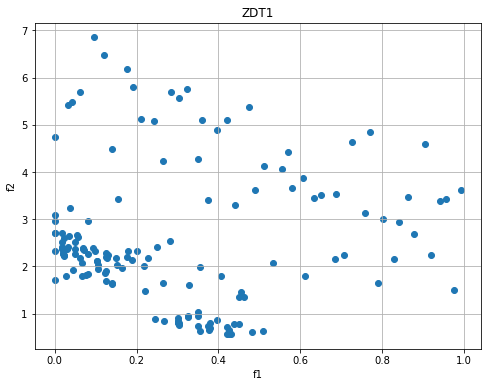

In [59]:
fig = plt.figure(figsize=(8, 6))
f1s = [fs['f1'] for fs in history['f']]
f2s = [fs['f2'] for fs in history['f']]
plt.scatter(f1s, f2s)
plt.title(benchmark_name)
plt.xlabel('f1')
plt.ylabel('f2')
plt.grid()
plt.show()

Text(0, 0.5, 'Hypervolume')

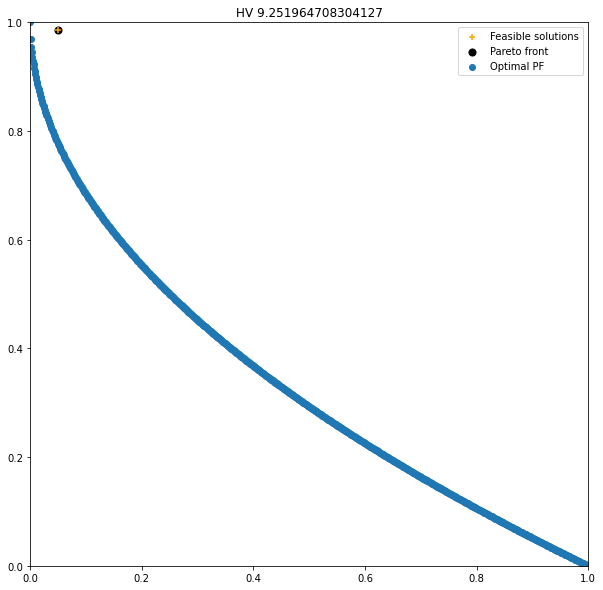

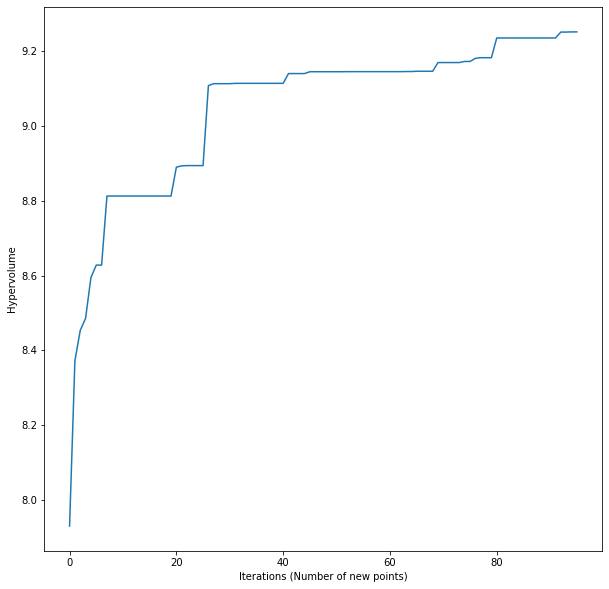

In [8]:
##### with NOISE!!!!!!!!!!!!!!!
m = solver.get_F()
pf = pareto_front(m, index=True)
pf = m[pf]
volume=compute_hypervolume(pf, [1, 10])

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(m[:, 0], m[:, 1], color='orange', marker='+', zorder=m.shape[0], label="Feasible solutions")
ax.scatter(pf[:, 0], pf[:, 1], color='k', s=50, label="Pareto front")
plt.title("HV "+str(volume))
tf = optimal_set()
ax.scatter(tf[:,0], tf[:,1], label="Optimal PF")
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.legend()

m = solver.get_F()
hv_temp = []

for index in range(num_initial_samples, len(m)):
    pf = pareto_front(m[:index], index=True)
    pf = m[pf]
    volume=compute_hypervolume(pf, [1, 10])
    hv_temp.append(volume)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(hv_temp)
plt.xlabel("Iterations (Number of new points)")
plt.ylabel("Hypervolume")

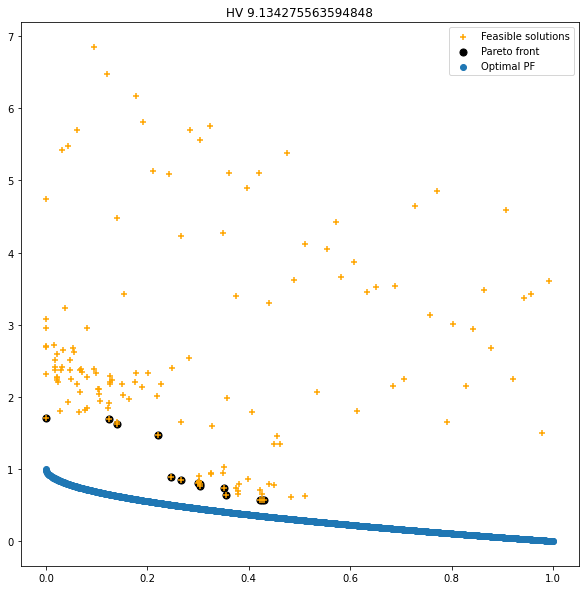

In [60]:
m = solver.get_F()
pf = pareto_front(m, index=True)
pf = m[pf]
volume=compute_hypervolume(pf, [1, 10])

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(m[:, 0], m[:, 1], color='orange', marker='+', zorder=m.shape[0], label="Feasible solutions")
ax.scatter(pf[:, 0], pf[:, 1], color='k', s=50, label="Pareto front")
plt.title("HV "+str(volume))
tf = optimal_set()
ax.scatter(tf[:,0], tf[:,1], label="Optimal PF")
# plt.ylim([0, 2])
plt.legend()

# fig, ax = plt.subplots(figsize=(10,10))
# plt.plot(hv_history)
# plt.xlabel("Iterations (Number of new points)")
# plt.ylabel("Hypervolume")

Text(0, 0.5, 'Hypervolume')

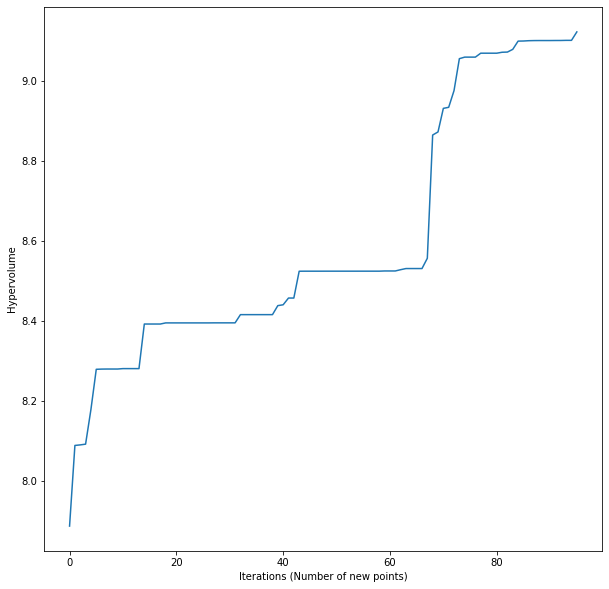

In [61]:
m = solver.get_F()
hv_temp = []

for index in range(num_initial_samples, len(m)):
    pf = pareto_front(m[:index], index=True)
    pf = m[pf]
    volume=compute_hypervolume(pf, [1, 10])
    hv_temp.append(volume)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot(hv_temp)
plt.xlabel("Iterations (Number of new points)")
plt.ylabel("Hypervolume")